# Complex Network Analysis

## Establish Trip Network

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df_july_2016_raw = pd.read_csv('July_trip_raw_data_2016.csv')

In [3]:
df_july_2016_count = df_july_2016_raw.value_counts().to_frame('counts').reset_index() 

Data has been cleaned where the number of trips happening from one node to another is now established in the 'counts' column. The weight of the link is now the numerical value of 'counts', which represent the number of trips happening between node 1 (start_station) and node 2 (end_station).

In [4]:
df_july_2016_count.head(5)

,start_station,end_station,counts
0,76,35,2298
1,35,268,1662
2,268,35,1476
3,177,35,1452
4,35,177,1447


## Establish the value of X

In [5]:
# now find the number of instances each 'counts' value occurs
counting_number = df_july_2016_count['counts'].value_counts(ascending= False)
counting_number.head(20)

1     15176
2      8441
3      5003
4      3916
5      2826
6      2244
7      1777
8      1551
9      1270
10     1100
11      977
12      893
13      769
14      749
15      611
16      565
17      488
18      450
20      409
19      393
Name: counts, dtype: int64

Since we want to remove outliers from our dataset, the cutoff for X should be at 5. This is when the gap between the usage of a bike station as start and end decreases drastically. We want to account for bike station that are regularly used, and we know that the regular user on average uses a bike sharing system 5 times per: https://www.sciencedirect.com/science/article/pii/S2211335519301202#:~:text=3.-,Results,%2C%2075th%20percentile%3A%209.6)
Therefore, it would be wise to say that we want bike stations that are used as regularly as the regular users use the bike sharing system. Furthermore, having the cutoff at X improves our prediction of user behaviors. We get to segment and predict which bike stations are regularly used and which are not by having a weighted link threshold.

In [6]:
# now to remove all links with weights less than or equal to 4
df_july_2016_bin = df_july_2016_count[df_july_2016_count['counts'] >= 5] # remove links smaller than 5

## Visualize and Explore

In [7]:
G = nx.from_pandas_edgelist(df_july_2016_bin, source = 'start_station', target = 'end_station')

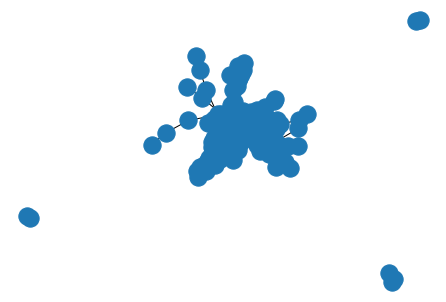

In [8]:
nx.draw(G)

(array([204.,  65.,  58.,  51.,  56.,  41.,  25.,   8.,   5.,   1.]),
 array([  1. ,  23.2,  45.4,  67.6,  89.8, 112. , 134.2, 156.4, 178.6,
        200.8, 223. ]),
 <BarContainer object of 10 artists>)

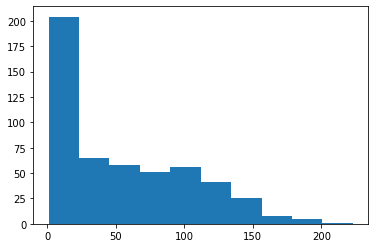

In [9]:
# degree distribution
plt.hist([v for k, v in nx.degree(G)])

It seems like most stations are not used more widely to locations other than 25 end stations. This makes sense because if you are at one station, it is likely that you will not travel to 25 other stations that are too far away. However, the distribution also indicates that there are a significant amount of stations that are used to travel to many other stations as well. This could potentially reveal that there are a significant amount of stations that are located very close to each other.

In [10]:
nx.density(G) # this density value is probably affected by those two isolated outliers 

0.10620368474146889

In [11]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [12]:
from operator import itemgetter
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print(d)

Top 10 nodes by degree:
(268, 223)
(35, 199)
(91, 188)
(77, 185)
(85, 181)
(177, 180)
(133, 178)
(94, 171)
(289, 170)
(287, 170)


In [13]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by betweenness centrality:")
for b in sorted_betweenness[:10]:
    print(b)
    
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:10]:
    print(b)

Top 10 nodes by betweenness centrality:
(76, 0.05736468928658095)
(4, 0.04808241446030134)
(35, 0.044514508620682354)
(177, 0.04414154950693802)
(459, 0.04061449991675809)
(268, 0.0323307679624885)
(71, 0.029150602026847945)
(518, 0.02738662290630391)
(69, 0.026601383389828866)
(90, 0.024850001037484762)
Top 10 nodes by eigenvector centrality:
(268, 0.12400947443048276)
(35, 0.11547730345769235)
(85, 0.11097182791461208)
(133, 0.10801736927087326)
(77, 0.10768925766856785)
(91, 0.10753204684096497)
(289, 0.10598721555824378)
(287, 0.10478403680977579)
(181, 0.10400666710594371)
(176, 0.10309827028754975)


Insert summary here later

## BSS Network Prediction

For the prediction of the binary network I will primarily use classification methods, such as logistic regression, artifical neural network, and naive bayes. Based on previous experiments, the naive bayes was the easiest to implement while being very similar to the artifical neural network in score.

In [14]:
df_july_2016_pred = pd.read_csv('July_trip_raw_data_2016.csv')

In [15]:
df_july_2016_pred = df_july_2016_pred.value_counts().to_frame('counts').reset_index()

In [16]:
count_compare = []
for index in range(len(df_july_2016_pred)):
    if df_july_2016_pred.iloc[index, 2] >= 5:
        count_compare.append(1)
    else:
        count_compare.append(0)

In [17]:
df_july_2016_pred['node_binary'] = count_compare

In [18]:
# function for calculating distance using latitude and longitude
import math
def calc_distance(lat1, lon1, lat2, lon2):
    R = 6373.0
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    dlon = lon2-lon1
    dlat = lat2-lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R*c
    return distance

In [19]:
df_divvy_2016 = pd.read_csv('Divvy_Station_2016.csv')
distance = []
for index in range(len(df_july_2016_pred)):
    start_station = df_july_2016_pred.iloc[index, 0]
    end_station = df_july_2016_pred.iloc[index, 1]
    row_start = df_divvy_2016.loc[df_divvy_2016['id']==start_station]
    row_end = df_divvy_2016.loc[df_divvy_2016['id']==end_station]
    lat_start = row_start.iloc[0, 2]
    long_start = row_start.iloc[0, 3]
    lat_end = row_end.iloc[0, 2]
    long_end = row_end.iloc[0, 3]
    distance1 = calc_distance(lat_start, long_start, lat_end, long_end)
    distance.append(distance1)

In [20]:
df_july_2016_pred['distance']= distance

In [21]:
# now apply it to the 2017 data
df_divvy_2017 = pd.read_csv('Divvy_Station_2017.csv') 
df_july_2017 = pd.read_csv('July_trip_raw_data_2017.csv')

In [22]:
# feature engineering!
distance_2017 = []
for index in range(len(df_july_2017)):
    start_station = df_july_2017.iloc[index, 0]
    end_station = df_july_2017.iloc[index, 1]
    row_start = df_divvy_2017.loc[df_divvy_2017['id']==start_station]
    row_end = df_divvy_2017.loc[df_divvy_2017['id']==end_station]
    lat_start = row_start.iloc[0, 3]
    long_start = row_start.iloc[0, 4]
    lat_end = row_end.iloc[0, 3]
    long_end = row_end.iloc[0, 4]
    distance1 = calc_distance(lat_start, long_start, lat_end, long_end)
    distance_2017.append(distance1)

In [23]:
df_july_2017['distance'] = distance_2017

In [24]:
df_july_2017 = df_july_2017.value_counts().to_frame('counts').reset_index()

In [25]:
count_compare_2017 = []
for index in range(len(df_july_2017)):
    if df_july_2017.iloc[index, 3] >= 5:
        count_compare_2017.append(1)
    else:
        count_compare_2017.append(0)

In [26]:
df_july_2017['node_binary'] = count_compare_2017

In [27]:
# Train test split
df_july_2017 = df_july_2017[df_july_2017.start_station != 623]
df_july_2017 = df_july_2017[df_july_2017.start_station != 624]
df_july_2017 = df_july_2017[df_july_2017.start_station != 625]
df_july_2017 = df_july_2017[df_july_2017.start_station != 626]
df_july_2017 = df_july_2017[df_july_2017.end_station != 623]
df_july_2017 = df_july_2017[df_july_2017.end_station != 624]
df_july_2017 = df_july_2017[df_july_2017.end_station != 625]
df_july_2017 = df_july_2017[df_july_2017.end_station != 626]

In [28]:
X_cols = ['start_station', 'distance', 'end_station']

y_cols = ['node_binary']

y2017 = df_july_2017[y_cols]
X2017 = df_july_2017[X_cols]

y = df_july_2016_pred[y_cols]
X = df_july_2016_pred[X_cols]

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB


# naive bayes
gnb = GaussianNB()
y_pred = gnb.fit(X, y).predict(X2017)
# since there is a mismatch between size of 2017 and 2016 data, we fill in filler values of 0 to indicate
# that those nodes will never been used for the y_pred data.
d = pd.DataFrame(0, index=np.arange(1674), columns=['node_binary'])
y = pd.concat([y, d])
print('test accuracy:', accuracy_score(y, y_pred))
print('macro f1 score:', f1_score(y, y_pred, average='macro'))

test accuracy: 0.6973774471004168
macro f1 score: 0.6925582798819518


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [30]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X1 = X
X2017_1 = X2017
X1 = sc.fit_transform(X1)
X2017_1 = sc.transform(X2017_1)

In [31]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, random_state=1)
y_unfiltered = df_july_2016_pred[y_cols]
clf.fit(X1, y_unfiltered)
clf.score(X1, y_unfiltered)

C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7342648471338734

In [32]:
# accuracy score
predictions_test = clf.predict(X2017_1)
test_score = accuracy_score(predictions_test, y2017)
print("score on test data: ", test_score)

score on test data:  0.7321337484389566


The artifical neural network worked the best for predicting the directed binary BSS network of July 2017 using the station information and the directed binary network of the July 2016 data. The result of the artifical neural network resulted in a 70% accuracy rate compared to the 2017 data.